## Doublet detector example - PBMCs
See https://github.com/swolock/woublet for the latest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figures



/Users/sam/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data prep

Download counts matrices from 10X

In [ ]:
# !wget http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
# !tar xfz pbmc8k_filtered_gene_bc_matrices.tar.gz


Load data

In [2]:
path = 'filtered_gene_bc_matrices/GRCh38/'
adata = sc.read(path + 'matrix.mtx', cache=True).T  # first time only
adata.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
adata.var_names_make_unique()

... reading from cache file ./cache/filtered_gene_bc_matrices-GRCh38-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Store total counts

In [3]:
adata.obs['n_counts'] = adata.X.sum(1).A1

Normalize, then store full normalized counts matrix

In [4]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=adata.obs['n_counts'].mean())

In [5]:
adata.raw = adata

Filter genes

In [6]:
sc.pp.filter_genes(adata, min_cells=3)

In [7]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)


In [8]:
print('{} genes pass filter'.format(filter_result['gene_subset'].sum()))

1189 genes pass filter


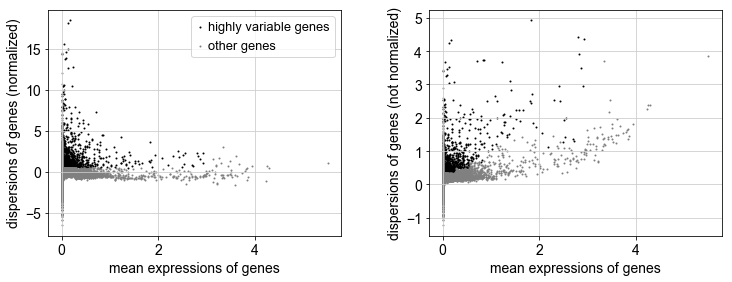

In [9]:
sc.pl.filter_genes_dispersion(filter_result)

In [10]:
adata = adata[:, filter_result.gene_subset]


Z-score normalize and run PCA

In [11]:
sc.pp.scale(adata)


In [12]:
sc.tl.pca(adata, n_comps=30)


Build k-nearest-neighbor graph

In [13]:
sc.pp.neighbors(adata, n_neighbors=5, use_rep='X_pca')

computing neighbors
    finished (0:00:04.72)


Get UMAP embedding

In [14]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:07.43)


## Doublet detector

Run the doublet detector  
(Expected multiplet rate from https://support.10xgenomics.com/permalink/3vzDu3zQjY0o2AqkkkI4CC)

In [15]:
sc.tl.woublet(adata, 
              sim_doublet_ratio=2, 
              n_neighbors=50, 
              expected_doublet_rate=0.06)


Simulating doublets
Running KNN classifier
computing neighbors
    finished (0:00:32.83)


Examine doublet score distribution.  
Manually set a threshold between the two peaks of the simulated doublet histogram.

366/8381 = 4.37% of cells are predicted doublets.
59.32% of doublets are predicted to be detectable.
Predicted total doublet rate = 7.36%


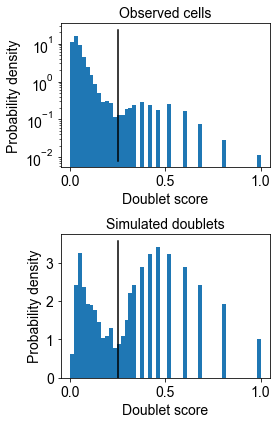

In [16]:
# set doublet score threshold:
threshold = 0.25

doub_obs = adata.obs['doublet_score']
doub_sim = adata.uns['sim_doublet_score']
adata.obs['predicted_doublets'] = pd.Categorical(['doublet' if x > threshold else 'singlet' for x in doub_obs])

fig, axs = pl.subplots(2, 1, figsize = (4, 6))

# histogram of scores for observed transcriptomes
ax = axs[0]
ax.hist(doub_obs, np.linspace(0, 1, 50), density = True);
ax.set_yscale('log')
ax.plot([threshold,threshold], ax.get_ylim(), c = 'black')
ax.set_title('Observed cells')
ax.set_xlabel('Doublet score')
ax.set_ylabel('Probability density')
ax.grid(False)

      
# histogram of scores for simulated doublets
ax = axs[1]
ax.hist(doub_sim, np.linspace(0, 1, 50), density = True);
ax.plot([threshold,threshold], ax.get_ylim(), c = 'black')
ax.set_title('Simulated doublets')
ax.set_xlabel('Doublet score')
ax.set_ylabel('Probability density')
ax.grid(False)

fig.tight_layout()


# print some stats
print('{}/{} = {:.2f}% of cells are predicted doublets.'.format(
    sum(doub_obs > threshold), 
    len(doub_obs),
    100*sum(doub_obs > threshold) / len(doub_obs)))
print('{:.2f}% of doublets are predicted to be detectable.'.format(
    100*sum(doub_sim > threshold) / len(doub_sim)))
print('Predicted total doublet rate = {:.2f}%'.format(
    100*sum(doub_obs > threshold) / len(doub_obs) / (sum(doub_sim > threshold) / len(doub_sim))))

Plot doublet scores and predictions on UMAP

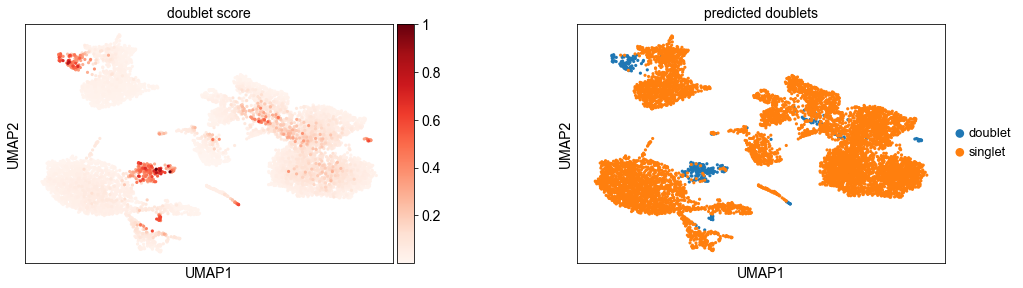

In [17]:
sc.pl.umap(adata, ['doublet_score', 'predicted_doublets'], color_map='Reds', size=40)
